DATA LOADING AND SPLITTING

In [1]:
import sys
import os
import warnings

warnings.simplefilter("ignore")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'proposal')))

from data_distribution.data_loading import *

X,y=load_data()
X, label_encod=preprocess_data_label_encoding(X)
X_train, X_test, y_train, y_test = data_split(X, y,test_size=0.2, random_state=45)

SIMPLE MODEL

Starting SVM model training.
SVM model trained successfully.
Evaluation results:
              precision    recall  f1-score   support

          NO       0.44      0.66      0.53        94
         YES       0.80      0.62      0.70       206

    accuracy                           0.63       300
   macro avg       0.62      0.64      0.61       300
weighted avg       0.69      0.63      0.65       300

Test set accuracy: 0.63


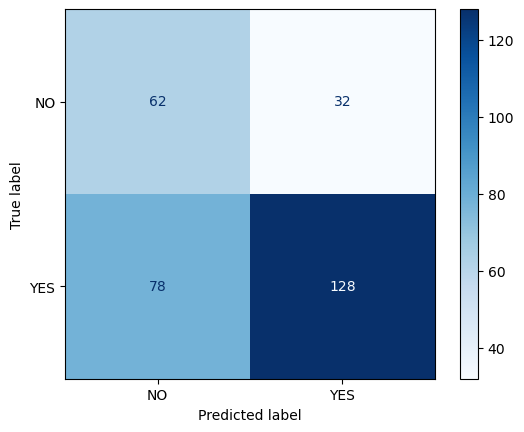

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import sys
import os

# Add the project path to the import list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..', 'proposal')))

from models.svm import *

# Initialize and train the SVM model
svm_model = SVMModel(kernel='linear', C=1.0, random_state=45, class_weight='balanced')
svm_model.train(X_train, y_train)

from sklearn.metrics import classification_report, balanced_accuracy_score

# Evaluate the model on the test set
y_test_pred = svm_model.predict(X_test)
accuracy_val = svm_model.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

SMOTE

Starting SVM model training.
SVM model trained successfully.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

          NO       0.43      0.59      0.50        94
         YES       0.77      0.65      0.71       206

    accuracy                           0.63       300
   macro avg       0.60      0.62      0.60       300
weighted avg       0.67      0.63      0.64       300

Test set accuracy: 0.63


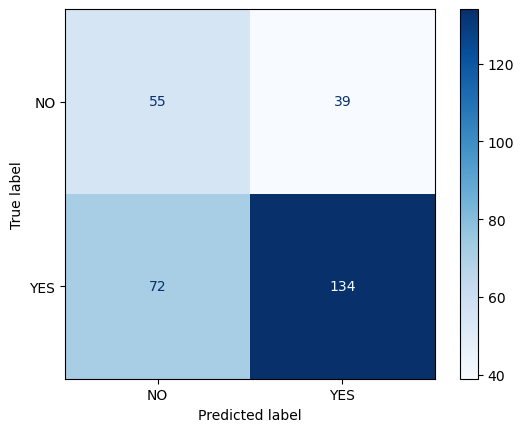

In [3]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set to handle class imbalance
smote = SMOTE(random_state=45)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize the SVM model
svm_model = SVMModel(kernel='linear', C=1.0, random_state=45)

# Train the SVM model using the balanced dataset
svm_model.train(X_train_resampled, y_train_resampled)

# Evaluate the SVM model
print("\nEvaluation on the test set:")
accuracy_val = svm_model.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_test_pred = svm_model.predict(X_test)

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

CROSS-VALIDATION


Starting hyperparameter tuning...
Fitting 10 folds for each of 32 candidates, totalling 320 fits

Best parameters found:
{'C': 100, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}

Best average accuracy during cross-validation:
0.790527950310559
Training the optimized model...
Starting SVM model training.
SVM model trained successfully.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

          NO       0.47      0.50      0.48        94
         YES       0.76      0.74      0.75       206

    accuracy                           0.66       300
   macro avg       0.61      0.62      0.62       300
weighted avg       0.67      0.66      0.67       300

Test set accuracy: 0.66


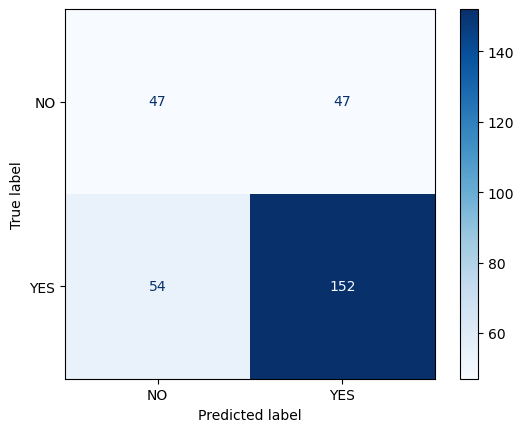

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the hyperparameter grid for SVM tuning
param_grid = {
    'C': [0.1, 1, 10, 100],                     # Regularization parameter
    'kernel': ['linear', 'rbf'],                # Kernel types
    'gamma': ['scale', 'auto'],                 # Kernel coefficient
    'class_weight': [None, 'balanced']          # Class weights
}

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=SVC(random_state=45), 
    param_grid=param_grid, 
    scoring='accuracy',  # Metric to optimize
    cv=10,               # Number of folds for cross-validation
    n_jobs=-1,           # Run in parallel
    verbose=2            # Log the process
)

# Train the model using GridSearchCV
print("\nStarting hyperparameter tuning...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Display the best hyperparameter results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest average accuracy during cross-validation:")
print(grid_search.best_score_)

# Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Create an instance of SVMModel using the optimized parameters
svm_model_optimized = SVMModel(
    kernel=grid_search.best_params_['kernel'],
    C=grid_search.best_params_['C'],
    gamma=grid_search.best_params_['gamma'],
    class_weight=grid_search.best_params_['class_weight']
)

# Train the optimized SVM model
print("Training the optimized model...")
svm_model_optimized.train(X_train_resampled, y_train_resampled)

# Evaluate the optimized model on the test set
print("\nEvaluation on the test set:")
accuracy_val = svm_model_optimized.evaluate(X_test, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_test_pred = svm_model_optimized.predict(X_test)

# Generate and display the confusion matrix for the test set
cm_val = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['NO', 'YES']).plot(cmap="Blues")

## Feature Engineering

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Principal Component Analysis (PCA) with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Display the variance explained by each PCA component
explained_variance = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_variance}")

# Feature engineering: Create interaction features
X['Age*Smoking'] = X['AGE'] * X['SMOKING']
X['Chronic*Anxiety'] = X['CHRONIC DISEASE'] * X['ANXIETY']
print("Added interaction features to the dataset.")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

# Standardize the data after adding the new features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an instance of SVMModel using the optimized parameters
svm_model_optimized = SVMModel(
    kernel=grid_search.best_params_['kernel'],
    C=grid_search.best_params_['C'],
    gamma=grid_search.best_params_['gamma'],
    class_weight=grid_search.best_params_['class_weight']
)

# Train the optimized SVM model
print("Training the optimized model...")
svm_model_optimized.train(X_train_scaled, y_train)

# Evaluate the optimized model on the test set
print("\nEvaluation on the test set:")
accuracy_val = svm_model_optimized.evaluate(X_test_scaled, y_test)
print(f"Test set accuracy: {accuracy_val:.2f}")

PCA Explained Variance: [0.11516975 0.09236047]
Added interaction features to the dataset.
Training the optimized model...
Starting SVM model training.
SVM model trained successfully.

Evaluation on the test set:
Evaluation results:
              precision    recall  f1-score   support

          NO       0.46      0.41      0.44        94
         YES       0.74      0.78      0.76       206

    accuracy                           0.66       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.65      0.66      0.66       300

Test set accuracy: 0.66


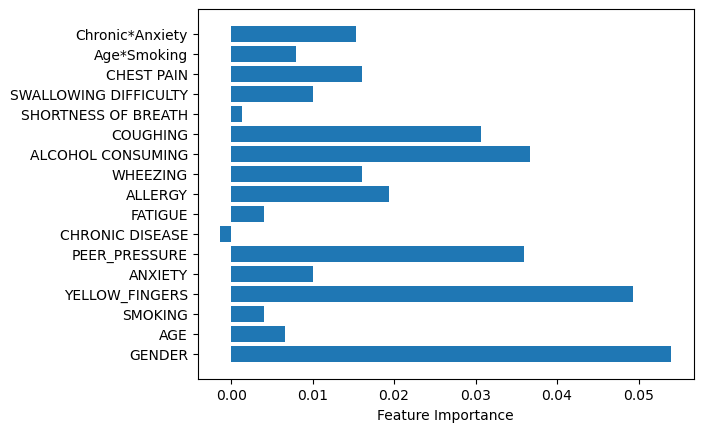

In [6]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Compute permutation importance for the model
result = permutation_importance(svm_model_optimized.model, X_test_scaled, y_test, scoring="accuracy")
feature_importance = result.importances_mean

# Visualize the most important features
plt.barh(range(len(feature_importance)), feature_importance)
plt.yticks(range(len(feature_importance)), X.columns)
plt.xlabel("Feature Importance")
plt.show()